# StyleGAN
Pre-trained model of 256x256 image resolution provided.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense, Input, LeakyReLU, Reshape, Lambda
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.layers import InstanceNormalization

import random
import math
import gdown

import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from functools import partial

print("Tensorflow", tf.__version__)
from packaging.version import parse as parse_version
assert parse_version(tf.__version__) < parse_version("2.4.0"), \
    f"Please install TensorFlow version 2.3.1 or older. Your current version is {tf.__version__}."

os.makedirs('./save_images', exist_ok=True)

Tensorflow 2.2.0


In [2]:
num_devices = 1
'''
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[1], True)
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")


strategy = tf.distribute.MirroredStrategy()
num_devices = strategy.num_replicas_in_sync
print('Number of devices: {}'.format(num_devices))
'''

'\ngpus = tf.config.experimental.list_physical_devices(\'GPU\')\ntf.config.experimental.set_memory_growth(gpus[1], True)\ntf.config.experimental.set_visible_devices(gpus[1], \'GPU\')\nlogical_gpus = tf.config.experimental.list_logical_devices(\'GPU\')\nprint(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")\n\n\nstrategy = tf.distribute.MirroredStrategy()\nnum_devices = strategy.num_replicas_in_sync\nprint(\'Number of devices: {}\'.format(num_devices))\n'

# Prepare Dataset

In [3]:
''' 
url = "https://drive.google.com/uc?id=17w_hePC1xO2eX83gAAF8ptKC59mTPQiL" 
gdown.download(url, 'celeba_hq.zip', quiet=False)
!unzip celeba_hq.zip -d ./celeba_hq
'''

' \nurl = "https://drive.google.com/uc?id=17w_hePC1xO2eX83gAAF8ptKC59mTPQiL" \ngdown.download(url, \'celeba_hq.zip\', quiet=False)\n!unzip celeba_hq.zip -d ./celeba_hq\n'

In [4]:
def load(res, image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [res, res],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32)
    image = (image /127.5) - 1
    return image

BATCH_SIZE = {2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 8, 8: 4, 9: 4, 10:4}
TRAIN_STEP_RATIO = {k: BATCH_SIZE[2]/v for k, v in BATCH_SIZE.items()}

def create_dataset_(data_path, res):
    res_log2 = int(np.log2(res))
    BUFFER_SIZE = 200
    images = glob(data_path)
    random.shuffle(images)
    batch_size = BATCH_SIZE[res_log2] * num_devices
    tf_list = tf.data.Dataset.from_tensor_slices(images)
    dataset = tf_list.map(partial(load, res),  num_parallel_calls= tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True).repeat()
    return dataset

DATA_PATH = "celeba_hq/train/**/*.jpg"
create_dataset = partial(create_dataset_, DATA_PATH)
    

### Utility function to display images after each epoch

In [5]:
def plot_images(images, log2_res, fname=''):    
    scales = {2:0.5,
             3:1,
             4:2,
             5:3,
             6:4,
             7:5,
             8:6,
             9:7,
             10:8}
    scale = scales[log2_res]
    
    grid_col = min(images.shape[0], int(16//scale))
    grid_row = 1

    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*scale, grid_row*scale))

    for row in range(grid_row):
        ax = axarr if grid_row==1 else axarr[row]
        for col in range(grid_col):
            ax[col].imshow(images[row*grid_col + col])
            ax[col].axis('off')
    plt.show()
    if fname:
        print("image name", fname)
        f.savefig(fname)

## Custom layers and blocks

In [6]:
class PixelNorm(Layer):
    def __init__(self, epsilon=1e-8):
        super(PixelNorm, self).__init__()
        self.epsilon = epsilon
        
    def call(self, input_tensor):
        return input_tensor / tf.math.sqrt(tf.reduce_mean(input_tensor**2, axis=-1, keepdims=True) + self.epsilon)


class MinibatchStd(Layer): 
    def __init__(self, group_size=4, epsilon=1e-8): 

        super(MinibatchStd, self).__init__() 
        self.epsilon = epsilon 
        self.group_size = group_size 
        
    def call(self, input_tensor): 

        n, h, w, c = input_tensor.shape 
        x = tf.reshape(input_tensor, [self.group_size, -1, h, w, c]) 
        group_mean, group_var = tf.nn.moments(x, axes=(0), keepdims=False) 
        group_std = tf.sqrt(group_var + self.epsilon) 
        avg_std = tf.reduce_mean(group_std, axis=[1,2,3], keepdims=True) 
        x = tf.tile(avg_std, [self.group_size, h, w, 1]) 

        return tf.concat([input_tensor, x], axis=-1) 
    
class FadeIn(Layer):
    @tf.function
    def call(self, input_alpha, a, b):
        alpha = tf.reduce_mean(input_alpha)
        y = alpha * a + (1. - alpha) * b
        return y
    
def wasserstein_loss(y_true, y_pred):
    
    return -tf.reduce_mean(y_true * y_pred)


class ConvBlock(Layer):
    def __init__(self, out_channels, kernel=3, gain=2, **kwargs):
        super(ConvBlock, self).__init__(kwargs)
        self.kernel = kernel
        self.out_channels = out_channels
        self.gain = gain
        self.pad = kernel!=1
        
    def build(self, input_shape):
        self.in_channels = input_shape[-1]

        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)        
        self.w = self.add_weight(shape=[self.kernel,
                                        self.kernel,
                                        self.in_channels,
                                        self.out_channels],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
        self.b = self.add_weight(shape=(self.out_channels,),
                                initializer='zeros',
                                trainable=True, name='bias')
        
        fan_in = self.kernel*self.kernel*self.in_channels
        self.scale = tf.sqrt(self.gain/fan_in)
        
    def call(self, inputs):
        if self.pad:
            x = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        else:
            x = inputs
        output = tf.nn.conv2d(x, self.scale*self.w, strides=1, padding="VALID") + self.b
        return output
    
class DenseBlock(Layer):
    def __init__(self, units, gain=2, lrmul=1, **kwargs):
        super(DenseBlock, self).__init__(kwargs)
        self.units = units
        self.gain = gain
        self.lrmul = lrmul
        
    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1./self.lrmul)        
        self.w = self.add_weight(shape=[self.in_channels,
                                        self.units],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
        self.b = self.add_weight(shape=(self.units,),
                                initializer='zeros',
                                trainable=True, name='bias')
        
        fan_in = self.in_channels
        self.scale = tf.sqrt(self.gain/fan_in)
        
    @tf.function(experimental_relax_shapes=True)
    def call(self, inputs):
        output = tf.add(tf.matmul(inputs, self.scale*self.w), self.b)
        return output*self.lrmul
    
class AddNoise(Layer):
        
    def build(self, input_shape):
        n, h, w, c = input_shape[0]

        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        self.B = self.add_weight(shape=[1, 1, 1, c],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
    def call(self, inputs):
        x, noise = inputs
        output = x + self.B * noise
        return output

class AdaIN(Layer):
    def __init__(self, gain=1, **kwargs):
        super(AdaIN, self).__init__(kwargs)
        self.gain = gain
        
    def build(self, input_shapes):
        x_shape = input_shapes[0]
        w_shape = input_shapes[1]

        self.w_channels = w_shape[-1]
        self.x_channels = x_shape[-1]
        
        self.dense_1 = DenseBlock(self.x_channels, gain=1)
        self.dense_2 = DenseBlock(self.x_channels, gain=1)
        
    @tf.function(experimental_relax_shapes=True)        
    def call(self, inputs):
        x, w = inputs
        ys = tf.reshape(self.dense_1(w), (-1, 1, 1, self.x_channels))
        yb = tf.reshape(self.dense_2(w), (-1, 1, 1, self.x_channels))
        
        output = ys*x + yb
        return output    

# Build StyleGAN

In [9]:
class StyleGAN(tf.keras.Model):
    @staticmethod
    def log2(res):
        return int(np.log2(res))
    
    def __init__(self, z_dim=512, res=64, start_res=4):
        super(StyleGAN, self).__init__()
        self.z_dim = z_dim
        self.res = res
        self.start_res = start_res
        self.alpha_input = Input(shape=(1), name='alpha')
        
        self.res_log2 = self.log2(res)
        self.start_res_log2 = self.log2(start_res)
        self.num_stages = self.res_log2 - self.start_res_log2 + 1
        self.filter_nums = {
            0: 512,
            1: 512,
            2: 512, # 4x4
            3: 512, # 8x8
            4: 512, # 16x16
            5: 512, # 32x32
            6: 256, # 64x64
            7: 128, # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16} # 1024x1024 
        
        self.g_input_shape = (start_res, start_res, self.filter_nums[self.start_res_log2])
        self.g_input = Input(self.g_input_shape)
        self.mapping = self.build_mapping()
        self.build_generators()
        self.build_discriminators()

        self.train_step_counter = 0
        self.phase = 'STABLE'
        self.current_res_log2 = self.res_log2       
        self.val_z = tf.random.normal((12, self.z_dim))        
        self.loss_weights = {'gradient_penalty':10, 'drift':0.001}

            
    def build_mapping(self):
        # Mapping Network
        z = Input(shape=(self.z_dim))
        w = PixelNorm()(z)
        for i in range(8):
            w = DenseBlock(512, lrmul=0.01)(w)
            w = LeakyReLU(0.2)(w)
        num_stages = self.res_log2 - self.start_res_log2 + 1
        w = tf.tile(tf.expand_dims(w, 1), (1, num_stages, 1))
        return Model(z, w, name='mapping')

    def build_to_rgb(self, res):
        filter_n = self.filter_nums[self.log2(res)]
        return Sequential([Input(shape=(res, res, filter_n)),
                           ConvBlock(3, 1, gain=1, activation=None,
                                  name=f'to_rgb_{res}x{res}_conv')],
                         name=f'to_rgb_{res}x{res}')
    
    def build_from_rgb(self, res):
        filter_n = self.filter_nums[self.log2(res)]        
        return Sequential([Input(shape=(res, res, 3)),
                           ConvBlock(filter_n, 1,
                                  name=f'from_rgb_{res}x{res}_conv'),
                           LeakyReLU(0.2)],
                         name=f'from_rgb_{res}x{res}')
    
    def build_g_block(self, res, input_shape):
        res_log2 = self.log2(res)
        res_name = f'{res}x{res}'
        filter_n = self.filter_nums[res_log2]

        input_tensor = Input(shape=input_shape)
        x = input_tensor        
        w = Input(shape=512)
        
        noise = Input(shape=(res, res, 1))

        if res_log2 > self.start_res_log2:
            x = UpSampling2D((2,2))(x)
            x = ConvBlock(filter_n, 3, name=f'gen_{res_name}_conv1')(x)

        x = AddNoise()([x, noise])
        x = LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)
        x = AdaIN()([x, w])
        
        # ADD NOISE
        x = ConvBlock(filter_n, 3, name=f'gen_{res_name}_conv2')(x)
        x = AddNoise()([x, noise])    
        x = LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)      
        x = AdaIN()([x, w])

        return Model([input_tensor, 
                      w, 
                      noise
                     ], x, 
                     name=f'genblock_{res}_x_{res}') 

    
    def build_generators(self):
        
        self.to_rgb = []
        self.g_blocks = []
        self.noise_inputs = []
        
        for res_log2 in range(self.start_res_log2, self.res_log2 + 1):
            res = 2**res_log2
            self.noise_inputs.append(Input(shape=(res, res, 1), name=f'noise_{res}x{res}'))
            self.to_rgb.append(self.build_to_rgb(res))
            
            if len(self.g_blocks) == 0:
                input_shape = self.g_input_shape
            else:
                input_shape = self.g_blocks[-1].output[0].shape
            self.g_blocks.append(\
                self.build_g_block(res, input_shape))

    def build_d_block(self, res, input_shape):
        res_log2 = self.log2(res)
        filter_n = self.filter_nums[res_log2]       
        input_tensor = Input(shape=input_shape, name=f'd_input_{res}_x_{res}')
        
        # First conv
        x = ConvBlock(filter_n, 3)(input_tensor)
        x = LeakyReLU(0.2)(x)
        
        # Second conv + downsample
        filter_n = self.filter_nums[res_log2 - 1]
        x = ConvBlock(filter_n, 3,)(x)
        x = LeakyReLU(0.2)(x)
        x = AveragePooling2D((2,2))(x)
        
        res = 2**res_log2
        return Model(input_tensor, x, 
                     name=f'd_block_{res}_x_{res}') 

    def build_d_base(self, res, input_shape):
        res_name = f'{res}x{res}'
        res_log2 = self.log2(res)
        filter_n = self.filter_nums[res_log2]
        
        input_tensor = Input(shape=input_shape)

        x = MinibatchStd()(input_tensor)

        x = ConvBlock(filter_n, 3, name=f'd_{res_name}_conv1')(x)
        x = LeakyReLU(0.2)(x)
        x = Flatten()(x)
        
        x = Dense(filter_n, name=f'd_{res_name}_dense1')(x)
        x = LeakyReLU(0.2)(x)

        x = Dense(1, name=f'd_{res_name}_dense2')(x)
        
        return Model(input_tensor, x, 
                     name=f'd_base_{res_name}')

    def build_discriminators(self):
        self.from_rgb = []
        self.d_blocks = []
        
        for res_log2 in range(self.start_res_log2, self.res_log2 + 1):
            res = 2**res_log2
            self.from_rgb.append(self.build_from_rgb(res))
            
            filter_n = self.filter_nums[res_log2]
            input_shape = (res, res, filter_n)
            if len(self.d_blocks) == 0:                
                d_block = self.build_d_base(res, input_shape)
            else:
                d_block = self.build_d_block(res, input_shape)
                
            self.d_blocks.append(d_block)
    
    def grow_g(self, res):
        
        res_log2 = self.log2(res)
        num_stages = res_log2 - self.start_res_log2 + 1
        w = Input(shape=(self.num_stages, 512), name='w')
        
        x = self.g_blocks[0]([self.g_input, 
                             w[:,0], 
                             self.noise_inputs[0]])

        if num_stages == 1:            
            rgb  = self.to_rgb[0](x)            
        else:            
            for i in range(1, num_stages-1):
            
                x = self.g_blocks[i]([x, 
                                     w[:,i], 
                                     self.noise_inputs[i]])
                #print(f"grow_generator mid, log2={i} w={i}, noise={i}", )
            
            old_rgb = self.to_rgb[num_stages-2](x)
            old_rgb = UpSampling2D((2,2))(old_rgb)
            print(f'to_rgb:{num_stages-2}')

            i = num_stages - 1
            x = self.g_blocks[i]([x, 
                                 w[:,i], 
                                 self.noise_inputs[i]])
            #print(f"grow_generator end, log2={i} w={i}, noise={i}", )

            new_rgb = self.to_rgb[i](x)
            #print(f'to_rgb:{i}')
            rgb = FadeIn()(self.alpha_input, new_rgb, old_rgb)
        
        self.generator = Model([self.g_input,
                                w,
                                self.alpha_input,
                                self.noise_inputs[:num_stages]], 
                                rgb, 
                        name=f'generator_{res}_x_{res}')         
    
    def grow_d(self, res):

        res_log2 = self.log2(res)
        idx = res_log2 - self.start_res_log2

        input_image = Input(shape=(res, res, 3), name='input_image')
        
        x = self.from_rgb[idx](input_image)
        x = self.d_blocks[idx](x)    
        #print(f'd_block[{idx}], from_rgb[{idx}]')
        if idx > 0 :  
            idx -= 1
            downsized_image = AveragePooling2D((2,2))(input_image)
            y = self.from_rgb[idx](downsized_image)            
            #print(f'from_rgb[{idx}]')
            x = FadeIn()(self.alpha_input, x, y)
            for i in range (idx, -1, -1):
                x = self.d_blocks[i](x)
                #print(f'd_block[{i}]')
            
        self.discriminator =  Model([input_image, self.alpha_input], x,
                     name=f'discriminator_{res}_x_{res}')
        
    def grow_model(self, res):
        tf.keras.backend.clear_session()
        res_log2 = self.log2(res)
        self.current_res_log2 = res_log2
        print(f"Growing model to {res}x{res}")
    
        self.grow_g(res)
        self.grow_d(res)

    def config(self, steps_per_epoch, phase, res,):
        self.steps_per_epoch = steps_per_epoch
        if res != 2**self.current_res_log2:
            self.grow_model(res)
        self.train_step_counter = 0
        self.phase = phase
        
    def compile(self, d_optimizer, g_optimizer,
                *args, **kwargs):

        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_weights = kwargs.pop('loss_weights',self.loss_weights)
        
        super(StyleGAN, self).compile(*args, **kwargs)        
                    
    def generate_noise(self, batch_size):
        noise = [tf.random.normal((batch_size, 2**res, 2**res, 1)) \
                 for res in range(self.start_res_log2, self.res_log2+1)]
        return noise
    
    def gradient_loss(self, grad):
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=np.arange(1,len(loss.shape)))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        return loss
   
    def train_step_g(self, real_images, alpha):
        batch_size = tf.shape(real_images)[0]
        real_labels = tf.ones(batch_size)
        
        z = tf.random.normal((batch_size, self.z_dim))
        w = self.mapping(z)
        const_input = tf.ones(tuple([batch_size]+list(self.g_input_shape)))
        noise = self.generate_noise(batch_size)

        with tf.GradientTape() as g_tape:
            fake_images = self.generator([const_input, w, alpha, noise])
            pred_fake = self.discriminator([fake_images, alpha])
            g_loss = wasserstein_loss(real_labels, pred_fake)
            
        gradients = g_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_weights))
                        
        return g_loss
    
    def train_step_d(self, real_images, alpha):
        ''' 
        Train discriminator with WGAN_GP loss
        '''
        batch_size = tf.shape(real_images)[0]
        const_input = tf.ones(tuple([batch_size]+list(self.g_input_shape)))
        noise = self.generate_noise(batch_size)
        
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)
        
        z = tf.random.normal((batch_size, self.z_dim))        
        w = self.mapping(z)
        fake_images = self.generator([const_input, w, alpha, noise])
        
        with tf.GradientTape() as gradient_tape,\
             tf.GradientTape() as total_tape:            
            # forward pass
            pred_fake = self.discriminator([fake_images, alpha])
            pred_real = self.discriminator([real_images, alpha])
                  
            epsilon = tf.random.uniform((batch_size,1,1,1))
            interpolates = epsilon*real_images + (1-epsilon)*fake_images
            gradient_tape.watch(interpolates)
            pred_fake_grad = self.discriminator([interpolates, alpha])
            
            # calculate losses
            loss_fake = wasserstein_loss(fake_labels, pred_fake)
            loss_real = wasserstein_loss(real_labels, pred_real)
            loss_fake_grad = wasserstein_loss(fake_labels, pred_fake_grad)
            
            # gradient penalty      
            gradients_fake = gradient_tape.gradient(loss_fake_grad, [interpolates])
            gradient_penalty = self.loss_weights['gradient_penalty'] * self.gradient_loss(gradients_fake)
     
            # drift loss
            all_pred = tf.concat([pred_fake, pred_real], axis=0)
            drift_loss = self.loss_weights['drift'] * tf.reduce_mean(all_pred**2)
            
            d_loss = loss_fake + loss_real + gradient_penalty + drift_loss


        # train discriminator
        gradients = total_tape.gradient(d_loss, self.discriminator.trainable_weights)            
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_weights))


        return d_loss
    
    def train_step(self, data):
        self.train_step_counter += 1
        
        if self.phase == 'TRANSITION':
            alpha_val = self.train_step_counter/self.steps_per_epoch
        elif self.phase == 'STABLE':
            alpha_val = 1.
        else:
            raise NotImplementedError
        
        alpha = tf.convert_to_tensor(np.array([[alpha_val]], dtype=np.float32))
        
        d_loss = self.train_step_d(data, alpha)
        g_loss = self.train_step_g(data, alpha)
        
        return {'d_loss':d_loss, 'g_loss':g_loss}        

    def call(self, inputs):
        pass
    
    def create(self, style_code=None, z=None, noise=None, batch_size=1):
        if style_code is None:
            if z is None:
                z = tf.random.normal((batch_size, self.z_dim))       
            style_code = self.mapping(z)
            
        if noise is None:
            noise = self.generate_noise(batch_size)
        else:
            assert len(noise) == batch_size

        const_input = tf.ones(tuple([batch_size]+list(self.g_input_shape)))        
        alpha = np.array([[1.]])
        images = self.generator([const_input, style_code, alpha, noise])
        images = np.clip((images*0.5 + 0.5)*255, 0, 255).astype(np.uint8)

        return images

    def save_checkpoint(self, path):
        print('Saving checkpoint',path)
        self.mapping.save(f'{path}/mapping')
        for i in range(self.num_stages):
            self.to_rgb[i].save(f'{path}/to_rgb_{i}')
            self.from_rgb[i].save(f'{path}/from_rgb_{i}')
            self.d_blocks[i].save(f'{path}/d_{i}')
            self.g_blocks[i].save(f'{path}/g_{i}')
                
    def load_checkpoint(self, path):
        self.mapping= tf.keras.models.load_model(f'{path}/mapping')
        num_stages = int(max([os.path.basename(d).split('_')[-1] for d in glob(path+'/d_*')]))
        for i in range(num_stages+1):
            self.to_rgb[i]= tf.keras.models.load_model(f'{path}/to_rgb_{i}')
            self.from_rgb[i]= tf.keras.models.load_model(f'{path}/from_rgb_{i}')
            self.d_blocks[i]= tf.keras.models.load_model(f'{path}/d_{i}')
            self.g_blocks[i]= tf.keras.models.load_model(f'{path}/g_{i}')

            
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        images = self.model.create(z=self.model.val_z)
        res = 2**self.model.current_res_log2
        prefix = f'res_{res}x{res}_{self.model.phase}'
        plot_images(images, self.model.current_res_log2, f"./save_images/{prefix}.jpg")        
        

Growing model to 4x4
10000/10000 [==============================] - ETA: 0s - d_loss: -6.4229 - g_loss: 5.3853
Epoch 00001: saving model to ./ckpts/stylegan_4x4_STABLE.ckpt
10000/10000 [==============================] - 661s 66ms/step - d_loss: -6.4226 - g_loss: 5.3850


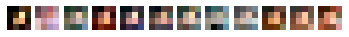

image name ./save_images/res_4x4_STABLE.jpg
Growing model to 8x8
to_rgb:0
10000/10000 [==============================] - ETA: 0s - d_loss: -6.7817 - g_loss: 4.3711
Epoch 00001: saving model to ./ckpts/stylegan_8x8_TRANSITION.ckpt
10000/10000 [==============================] - 1127s 113ms/step - d_loss: -6.7814 - g_loss: 4.3713


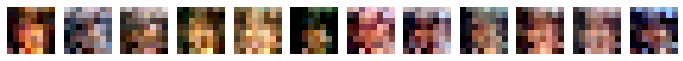

image name ./save_images/res_8x8_TRANSITION.jpg
10000/10000 [==============================] - ETA: 0s - d_loss: -5.1187 - g_loss: 3.0733
Epoch 00001: saving model to ./ckpts/stylegan_8x8_STABLE.ckpt
10000/10000 [==============================] - 1128s 113ms/step - d_loss: -5.1188 - g_loss: 3.0731


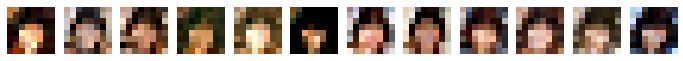

image name ./save_images/res_8x8_STABLE.jpg
Growing model to 16x16
to_rgb:1
10000/10000 [==============================] - ETA: 0s - d_loss: -6.8665 - g_loss: 5.2496
Epoch 00001: saving model to ./ckpts/stylegan_16x16_TRANSITION.ckpt
10000/10000 [==============================] - 1607s 161ms/step - d_loss: -6.8667 - g_loss: 5.2496


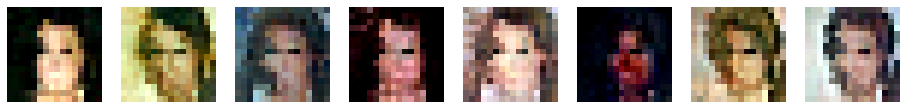

image name ./save_images/res_16x16_TRANSITION.jpg
10000/10000 [==============================] - ETA: 0s - d_loss: -4.5871 - g_loss: 3.2373
Epoch 00001: saving model to ./ckpts/stylegan_16x16_STABLE.ckpt
10000/10000 [==============================] - 1604s 160ms/step - d_loss: -4.5874 - g_loss: 3.2363


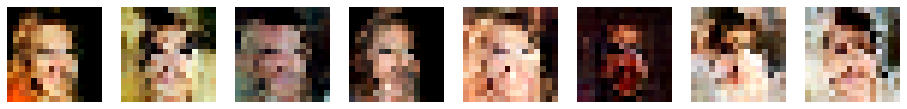

image name ./save_images/res_16x16_STABLE.jpg
Growing model to 32x32
to_rgb:2
10000/10000 [==============================] - ETA: 0s - d_loss: -8.3730 - g_loss: 5.9191
Epoch 00001: saving model to ./ckpts/stylegan_32x32_TRANSITION.ckpt
10000/10000 [==============================] - 2911s 291ms/step - d_loss: -8.3737 - g_loss: 5.9196


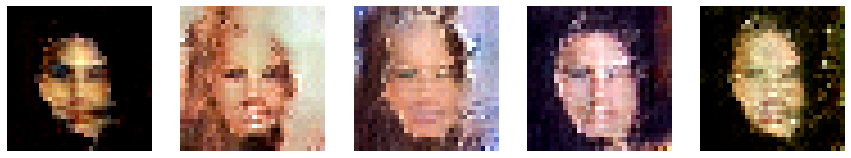

image name ./save_images/res_32x32_TRANSITION.jpg
10000/10000 [==============================] - ETA: 0s - d_loss: -5.7730 - g_loss: 3.9223
Epoch 00001: saving model to ./ckpts/stylegan_32x32_STABLE.ckpt
10000/10000 [==============================] - 2909s 291ms/step - d_loss: -5.7729 - g_loss: 3.9219


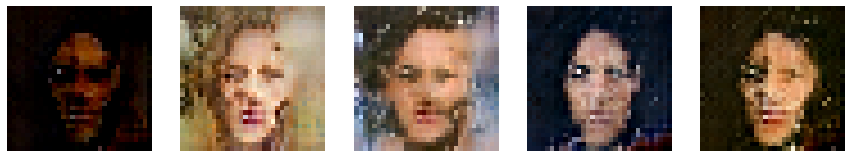

image name ./save_images/res_32x32_STABLE.jpg
Growing model to 64x64
to_rgb:3
10000/10000 [==============================] - ETA: 0s - d_loss: -12.4371 - g_loss: 8.9181
Epoch 00001: saving model to ./ckpts/stylegan_64x64_TRANSITION.ckpt
10000/10000 [==============================] - 5482s 548ms/step - d_loss: -12.4367 - g_loss: 8.9156


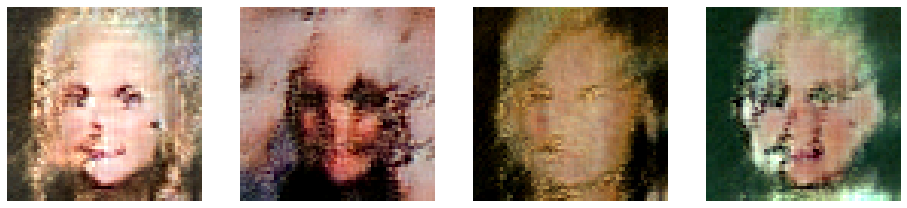

image name ./save_images/res_64x64_TRANSITION.jpg
10000/10000 [==============================] - ETA: 0s - d_loss: -9.4669 - g_loss: 6.9247
Epoch 00001: saving model to ./ckpts/stylegan_64x64_STABLE.ckpt
10000/10000 [==============================] - 5483s 548ms/step - d_loss: -9.4662 - g_loss: 6.9244


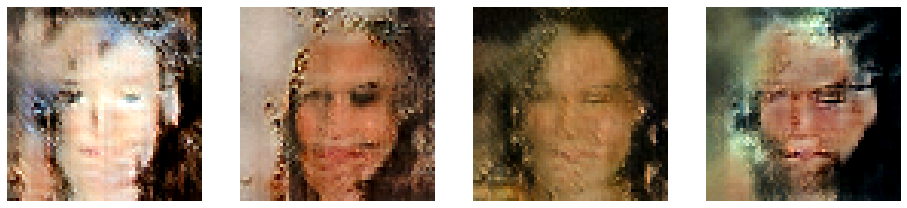

image name ./save_images/res_64x64_STABLE.jpg
Growing model to 128x128
to_rgb:4
 2335/20000 [==>...........................] - ETA: 3:09:50 - d_loss: -9.3157 - g_loss: 7.9248

KeyboardInterrupt: 

In [11]:
START_RES = 4
TARGET_RES = 256
STEPS_PER_EPOCH = 10000

model = StyleGAN(start_res=START_RES, res=TARGET_RES)

opt_cfg = {'learning_rate':1e-3, 'beta_1':0.0, 'beta_2':0.99, 'epsilon':1e-8}

model.compile(d_optimizer=Adam(**opt_cfg),
              g_optimizer=Adam(**opt_cfg), 
              loss_weights = {'gradient_penalty':10, 'drift':0.001},
              run_eagerly=True)


start_res_log2 = int(np.log2(START_RES))
target_res_log2 = int(np.log2(TARGET_RES))
for res_log2 in range(start_res_log2, target_res_log2+1):
    res = 2**res_log2
    for phase in ['TRANSITION', 'STABLE']:
        if res==START_RES and phase=='TRANSITION':
            continue

        steps = int(TRAIN_STEP_RATIO[res_log2] * STEPS_PER_EPOCH/num_devices)
            
        train_ds = create_dataset(res)
        
        checkpoint_path = f'./ckpts/stylegan_{res}x{res}_{phase}.ckpt'
        checkpoint_cb = ModelCheckpoint(
            filepath=checkpoint_path, 
            save_weights_only=True, 
            verbose=1)
        
        model.config(steps_per_epoch=steps,
                     res=res,
                     phase=phase)
                
        model.fit(train_ds,
                  epochs=1, 
                  steps_per_epoch=steps,
                  callbacks=[checkpoint_cb])
        
        images = model.create(z=model.val_z)
        prefix = f'res_{res}x{res}_{model.phase}'
        plot_images(images, res_log2, f"./save_images/{prefix}.jpg")        
        
            

## Training. You can skip this step to load pretrained model

Growing model to 4x4
10000/10000 [==============================] - ETA: 0s - d_loss: -6.2970 - g_loss: 4.9254
Epoch 00001: saving model to ./ckpts/stylegan_4x4_STABLE.ckpt
10000/10000 [==============================] - 630s 63ms/step - d_loss: -6.2970 - g_loss: 4.9254


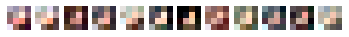

image name ./save_images/res_4x4_STABLE.jpg
Growing model to 8x8
to_rgb:0
10000/10000 [==============================] - ETA: 0s - d_loss: -6.9182 - g_loss: 4.4071
Epoch 00001: saving model to ./ckpts/stylegan_8x8_TRANSITION.ckpt
10000/10000 [==============================] - 1099s 110ms/step - d_loss: -6.9182 - g_loss: 4.4079


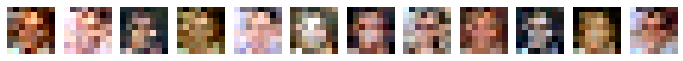

image name ./save_images/res_8x8_TRANSITION.jpg
10000/10000 [==============================] - ETA: 0s - d_loss: -4.8301 - g_loss: 2.7362
Epoch 00001: saving model to ./ckpts/stylegan_8x8_STABLE.ckpt
10000/10000 [==============================] - 1099s 110ms/step - d_loss: -4.8299 - g_loss: 2.7357


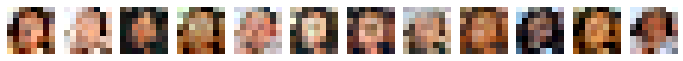

image name ./save_images/res_8x8_STABLE.jpg
Growing model to 16x16
to_rgb:1
10000/10000 [==============================] - ETA: 0s - d_loss: -7.1852 - g_loss: 4.8830
Epoch 00001: saving model to ./ckpts/stylegan_16x16_TRANSITION.ckpt
10000/10000 [==============================] - 1596s 160ms/step - d_loss: -7.1850 - g_loss: 4.8832


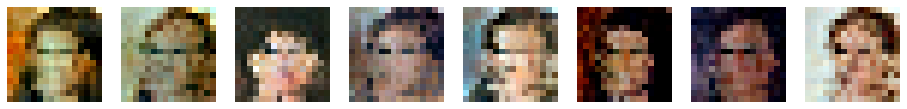

image name ./save_images/res_16x16_TRANSITION.jpg
10000/10000 [==============================] - ETA: 0s - d_loss: -4.7122 - g_loss: 2.9065
Epoch 00001: saving model to ./ckpts/stylegan_16x16_STABLE.ckpt
10000/10000 [==============================] - 1594s 159ms/step - d_loss: -4.7119 - g_loss: 2.9067


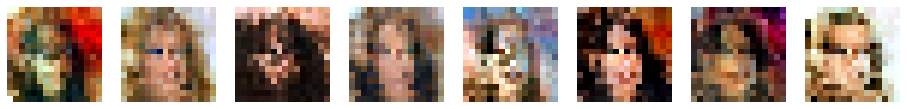

image name ./save_images/res_16x16_STABLE.jpg
Growing model to 32x32
to_rgb:2
10000/10000 [==============================] - ETA: 0s - d_loss: -7.1804 - g_loss: 4.6272
Epoch 00001: saving model to ./ckpts/stylegan_32x32_TRANSITION.ckpt
10000/10000 [==============================] - 2931s 293ms/step - d_loss: -7.1802 - g_loss: 4.6278


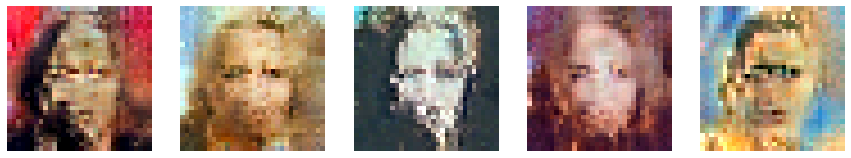

image name ./save_images/res_32x32_TRANSITION.jpg
10000/10000 [==============================] - ETA: 0s - d_loss: -5.4272 - g_loss: 3.1840
Epoch 00001: saving model to ./ckpts/stylegan_32x32_STABLE.ckpt
10000/10000 [==============================] - 2930s 293ms/step - d_loss: -5.4269 - g_loss: 3.1826


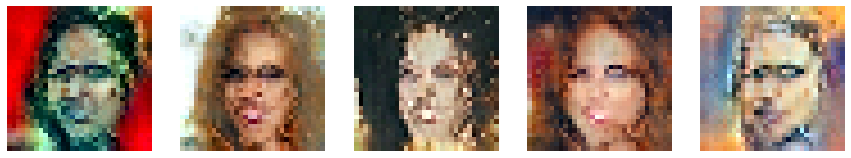

image name ./save_images/res_32x32_STABLE.jpg
Growing model to 64x64
to_rgb:3
 5833/10000 [================>.............] - ETA: 38:09 - d_loss: -11.1218 - g_loss: 7.0621

KeyboardInterrupt: 

In [10]:

start_res_log2 = int(np.log2(START_RES))
target_res_log2 = int(np.log2(TARGET_RES))
for res_log2 in range(start_res_log2, target_res_log2+1):
    res = 2**res_log2
    for phase in ['TRANSITION', 'STABLE']:
        if res==START_RES and phase=='TRANSITION':
            continue

        steps = int(TRAIN_STEP_RATIO[res_log2] * STEPS_PER_EPOCH/num_devices)
            
        train_ds = create_dataset(res)
        
        checkpoint_path = f'./ckpts/stylegan_{res}x{res}_{phase}.ckpt'
        checkpoint_cb = ModelCheckpoint(
            filepath=checkpoint_path, 
            save_weights_only=True, 
            verbose=1)
        
        model.config(steps_per_epoch=steps,
                     res=res,
                     phase=phase)
                
        model.fit(train_ds,
                  epochs=1, 
                  steps_per_epoch=steps,
                  callbacks=[checkpoint_cb])
        
        images = model.create(z=model.val_z)
        prefix = f'res_{res}x{res}_{model.phase}'
        plot_images(images, res_log2, f"./save_images/{prefix}.jpg")        
        
            

# Uncomment to pre-trained load model
Fill in the [form](https://forms.gle/5JiWL6KhFaKknzzV8) to get the download URL.

In [ ]:
# Download models
'''
url = None
gdown.download(url, 'checkpoints.zip', quiet=False)
!unzip checkpoints.zip -d .
'''

In [ ]:
# Load models
model.load_weights('./ckpts/stylegan_256x256_STABLE.ckpt')

# Generate Images

In [ ]:
def generate_image(w, noise):
    const_input = tf.ones((1,START_RES,START_RES,512))
    w = tf.expand_dims(w, 0)
    #noise = tf.expand_dims(noise, 0)
    alpha = np.array([[1.]])
    images = model.generator([const_input, w, alpha, noise])
    images = np.clip((images*0.5 + 0.5)*255, 0, 255)
    return images.astype(np.uint8)

In [ ]:
batch_size = 8
z = tf.random.truncated_normal((batch_size, 512))
w = model.mapping(z)
noise = model.generate_noise(batch_size)
images = model.create(z)
plot_images(images, 7)

# Style Mixing

In [ ]:
# Select style from above
w_a = w[4]
w_b = w[5]

noise_a = model.generate_noise(batch_size)
image_a = generate_image(w_a, noise_a)[0]
noise_b = model.generate_noise(batch_size)
image_b = generate_image(w_b, noise_b)[0]

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


@interact
def explore_latent_variable(w0 = (0,1.0,0.05),
                            w1 = (0,1.0,0.05),
                            w2 = (0,1.0,0.05),
                            w3 = (0,1.0,0.05),
                            #w4 = (0,1.0,0.05),
                            #w5 = (0,1.0,0.05),
                            #w6 = (0,1.0,0.05),
                            #w7 = (0,1.0,0.05),
                            noise_src = widgets.Select(options=['Left', 'Right'], value='Left', 
                                                       description='Pose from:')
):
    w4 = w5 = w6 = w7 = 0.5
    w_mix = [w0*w_a[0]+(1-w0)*w_b[0],
             w1*w_a[1]+(1-w1)*w_b[1],
             w2*w_a[2]+(1-w2)*w_b[2],
             w3*w_a[3]+(1-w3)*w_b[3],
             w4*w_a[4]+(1-w4)*w_b[4],
             w5*w_a[5]+(1-w5)*w_b[5],
             w6*w_a[6]+(1-w6)*w_b[6],
             #w7*w_a[7]+(1-w7)*w_b[7],
            ]
    noise = noise_a if noise_src == 'Right' else noise_b
    image_mix = generate_image(w_mix, noise)[0]
    images = np.stack([image_b, image_a, image_mix], axis=0)
    plot_images(images, 8)
    


## Same Style, Different Noise

In [ ]:
noise = model.generate_noise(batch_size)
images = generate_image(w[5], noise)
plot_images(images, 8)

In [ ]:
tf.keras.utils.plot_model(model.discriminator, show_shapes=True)

In [ ]:
tf.keras.utils.plot_model(model.generator, show_shapes=True)

In [ ]:
model.discriminator.summary()

In [ ]:
model.generator.summary()